<a href="https://colab.research.google.com/github/KetilIversen/ADE-PINN-Masters-Thesis-Code/blob/main/PINN/PINN_2D_ADE_Inverse_Weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D ADE Inverse

Install needed for latin hypercube sampling (lhs)

In [2]:
!pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=2baa32504172b0159a0e0474ec65b24ee03547a4e40ff923c6c6da24c5d7c26b
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


All necessary imports

In [3]:
#@title Imports
# Imports related to preprocessing of data and tensorflow
import sys
import os
import time
from datetime import datetime
import tensorflow as tf
import numpy as np
import scipy.io
import tensorflow_probability as tfp
from pyDOE import lhs

# Imports related to plotting
from scipy.io import savemat
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Imports related to animations
import matplotlib.animation
from IPython.display import HTML

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

The following two functions are for loading the data and preprocessing. Either through sparse measurements or dense measurements.

In [4]:
#@title Load data function
def LoadData(path, N_u, N_m, noise, inc_bounds, prcnt, sparse, random_pos, timestep, method):

  if sparse==False:
    # Getting the data with random distribution
    x, y, t, X, Y, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb = prep_data_dense(path, N_u, noise, inc_bounds, prcnt)
    return x, y, t, X, Y, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb
  else:
    # Getting the data with sparse distribution
    x, y, t, X, Y, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb = prep_data_sparse_measurements(path, N_m, random_pos, timestep, inc_bounds, prcnt, method, noise)
    return x, y, t, X, Y, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb

In [5]:
#@title Data prep sparse
def prep_data_sparse_measurements(path, N_m, random_pos, timestep, inc_bounds, prcnt, method, noise):
    # Reading external data
    data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['timesteps'].flatten()[:,None] # T x 1
    y = data['y'].flatten()[:,None] # N x 1
    x = data['x'].flatten()[:,None] # N x 1

    Nx = x.shape[0]
    Ny = y.shape[0]
    Nt = t.shape[0]

    if random_pos:
      rnd_points = np.random.choice(Nx*Ny, N_m, replace=False)
    else:
      if method == 1:
        rnd_points = np.linspace(0,Nx*Ny, N_m, endpoint=False, dtype=np.dtype(int))
      if method == 2:
        step = np.floor(Nx*Ny/(N_m+1))
        rnd_points = np.linspace(step, Nx*Ny-step, N_m, dtype=np.dtype(int))
      if method ==3:
        rnd_points = np.linspace(0, Nx*Ny-1, N_m, dtype=np.dtype(int))
    
    for i in range(N_m):
      next_points = np.arange(rnd_points[i]*Nt, rnd_points[i]*Nt + Nt, timestep)
      if i == 0:
        sample_idx = next_points
      else:  
        sample_idx = np.append(sample_idx, next_points)

    # Keeping the 3D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['u']) # T x N x N

    # Meshing x and t in 3D (100,100,2000)
    X, Y, T = np.meshgrid(x,y,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))

    # Preparing the testing u_star
    u_star = np.swapaxes(Exact_u,0,1)
    u_star = u_star.flatten()[:,None] 

    X_u_train = X_star[sample_idx,:]
    u_train = u_star[sample_idx,:]

    # Noise       
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    u_star = u_star + noise*np.std(u_star)*np.random.randn(u_star.shape[0], u_star.shape[1])

    if inc_bounds == True:
      # Getting the initial conditions (t=0)
      xx1 = np.hstack((X[:,:,0:1].flatten()[:,None], Y[:,:,0:1].flatten()[:,None], T[:,:,0:1].flatten()[:,None]))
      uu1 = Exact_u[:,:,0:1].flatten()[:,None]
      # Getting the lowest boundary conditions (x=0) 
      xx2 = np.hstack((X[0:1,:,:].flatten()[:,None], Y[0:1,:,:].flatten()[:,None], T[0:1,:,:].flatten()[:,None]))
      uu2 = Exact_u[0:1,:,:].flatten()[:,None]
      # Getting the highest boundary conditions (x=1) 
      xx3 = np.hstack((X[-1:,:,:].flatten()[:,None], Y[-1:,:,:].flatten()[:,None], T[-1:,:,:].flatten()[:,None]))
      uu3 = Exact_u[-1:,:,:].flatten()[:,None]
      # Getting the lowest boundary conditions (y=0) 
      xx4 = np.hstack((X[:,0:1,:].flatten()[:,None], Y[:,0:1,:].flatten()[:,None], T[:,0:1,:].flatten()[:,None]))
      uu4 = Exact_u[:,0:1,:].flatten()[:,None]
      # Getting the highest boundary conditions (y=1) 
      xx5 = np.hstack((X[:,-1:,:].flatten()[:,None], Y[:,-1:,:].flatten()[:,None], T[:,-1:,:].flatten()[:,None]))
      uu5 = Exact_u[:,-1:,:].flatten()[:,None]
      # Selecting random boundary points
      X_u_bounds = np.vstack([xx1, xx2, xx3, xx4, xx5])
      u_bounds = np.vstack([uu1, uu2, uu3, uu4, uu5])
      size = X_u_bounds.shape[0]
      samples = np.int(np.floor(X_u_bounds.shape[0]*prcnt))
      rnd_bounds = np.random.choice(size, samples, replace=False)
      X_u_bounds = X_u_bounds[rnd_bounds,:]
      u_bounds = u_bounds[rnd_bounds,:]
      # Stacking them in multidimensional tensors for training
      X_u_train = np.vstack([X_u_train, X_u_bounds])
      u_train = np.vstack([u_train, u_bounds])

    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0) 
    return x, y, t, X, Y, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb

In [6]:
#@title Data prep dense
def prep_data_dense(path, N_u, noise, inc_bounds, prcnt):
    # Reading external data
    data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['timesteps'].flatten()[:,None] # T x 1
    y = data['y'].flatten()[:,None] # N x 1
    x = data['x'].flatten()[:,None] # N x 1
    

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['u']) # T x N x N

    # Meshing x and t in 2D (100,100,100)
    X, Y, T = np.meshgrid(x,y,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))
    
    # Preparing the testing u_star
    u_star = np.swapaxes(Exact_u,0,1)
    u_star = u_star.flatten()[:,None]

  
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    # Noise       
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    u_star = u_star + noise*np.std(u_star)*np.random.randn(u_star.shape[0], u_star.shape[1])
    
    if inc_bounds == True:
      # Getting the initial conditions (t=0)
      xx1 = np.hstack((X[:,:,0:1].flatten()[:,None], Y[:,:,0:1].flatten()[:,None], T[:,:,0:1].flatten()[:,None]))
      uu1 = Exact_u[:,:,0:1].flatten()[:,None]
      # Getting the lowest boundary conditions (x=0) 
      xx2 = np.hstack((X[0:1,:,:].flatten()[:,None], Y[0:1,:,:].flatten()[:,None], T[0:1,:,:].flatten()[:,None]))
      uu2 = Exact_u[0:1,:,:].flatten()[:,None]
      # Getting the highest boundary conditions (x=1) 
      xx3 = np.hstack((X[-1:,:,:].flatten()[:,None], Y[-1:,:,:].flatten()[:,None], T[-1:,:,:].flatten()[:,None]))
      uu3 = Exact_u[-1:,:,:].flatten()[:,None]
      # Getting the lowest boundary conditions (y=0) 
      xx4 = np.hstack((X[:,0:1,:].flatten()[:,None], Y[:,0:1,:].flatten()[:,None], T[:,0:1,:].flatten()[:,None]))
      uu4 = Exact_u[:,0:1,:].flatten()[:,None]
      # Getting the highest boundary conditions (y=1) 
      xx5 = np.hstack((X[:,-1:,:].flatten()[:,None], Y[:,-1:,:].flatten()[:,None], T[:,-1:,:].flatten()[:,None]))
      uu5 = Exact_u[:,-1:,:].flatten()[:,None]
      # Selecting random boundary points
      X_u_bounds = np.vstack([xx1, xx2, xx3, xx4, xx5])
      u_bounds = np.vstack([uu1, uu2, uu3, uu4, uu5])
      size = X_u_bounds.shape[0]
      samples = np.int(np.floor(X_u_bounds.shape[0]*prcnt))
      rnd_bounds = np.random.choice(size, samples, replace=False)
      X_u_bounds = X_u_bounds[rnd_bounds,:]
      u_bounds = u_bounds[rnd_bounds,:]
      # Stacking them in multidimensional tensors for training
      X_u_train = np.vstack([X_u_train, X_u_bounds])
      u_train = np.vstack([u_train, u_bounds])

    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0) 
    return x, y, t, X, Y, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb

In [7]:
#@title Logger class
class Logger(object):
    def __init__(self, frequency=10):
        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time).strftime("%H:%M:%S")

    def __get_error_u(self):
        return self.error_fn()

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn

    def log_train_start(self, model):
        print("\nTraining started")
        print("================")
        self.model = model
        print(self.model.summary())
    
    def log_train_epoch(self, epoch, loss, current_best_loss, custom=""):
        if epoch % self.frequency == 0:
            print(f"{'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  best loss = {current_best_loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

    def log_train_opt(self, name):
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, loss, current_best_loss, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  loss = {loss:.4e}  best loss = {current_best_loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)
        print('Applying the weights at the best epoch to the model...')
        return self.__get_elapsed()

In [8]:
#@title Extract data from PINN
def ExtractData(pinn, X_star, X_u_train):

  # Getting the model predictions, over dense (x,y,t) domain
  X_star_batches = np.array_split(X_star,1000)
  u_pred, _ = pinn.predict(X_star_batches[0])
  for i in range(len(X_star_batches)-1):
    u_pred_batch, _ = pinn.predict(X_star_batches[i+1])
    u_pred = np.vstack((u_pred,u_pred_batch))

  # Getting the model prediction, over training (x,y,t)
  X_u_train_batches = np.array_split(X_u_train,1000)
  u_train_pred, _ = pinn.predict(X_u_train_batches[0])
  for i in range(len(X_u_train_batches)-1):
    u_train_batch, _ = pinn.predict(X_u_train_batches[i+1])
    u_train_pred = np.vstack((u_train_pred,u_train_batch))

  u_train_pred = u_train_pred.flatten()[:,None] 
  
  N_x = x.shape[0]
  N_y = y.shape[0]
  N_t = t.shape[0]

  X_plot = X_star.reshape(N_x,N_y,N_t,3)
  u_plot = u_pred.reshape(N_x,N_y,N_t)
  u_star_plot = u_star.reshape(N_x,N_y,N_t)
  X_test = X_plot[:,:,0,0]
  Y_test = X_plot[:,:,0,1]

  trained_weights = pinn.get_weights()
  pred_params = pinn.get_params(numpy=True)

  return X_test, Y_test, u_star_plot, u_plot, u_train_pred, trained_weights, pred_params

In [9]:
#@title Error function
def error():
    l1, l2, l3 = pinn.get_params(numpy=True)
    l1_star, l2_star, l3_star = lambdas_star
    error_lambda_1 = np.abs(l1 - l1_star) #/ l1_star
    error_lambda_2 = np.abs(l2 - l2_star) #/ l2_star
    return (error_lambda_1 + error_lambda_2) / 2

In [10]:
#@title Training data plotter
def TrainingDataPlotter(X_u_train, ub, lb):

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X_u_train[:,0],X_u_train[:,1],X_u_train[:,2], marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')

    plt.show()


    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(X_u_train[:,0],X_u_train[:,1], marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(lb[0], ub[0])
    ax.set_ylim(lb[1], ub[1])

    plt.show()

    print('Amount of training data: ' + str(X_u_train.shape[0]))

In [11]:
#@title Discrete plotter
def DiscretePlotter(t,X_test,Y_test,u_plot,ub,zmax=0.3,zmin=0.0,cmap='rainbow'):

    def figsize(scale, nplots = 1):
        fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
        inches_per_pt = 1.0/72.27                       # Convert pt to inch
        golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
        fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
        fig_height = nplots*fig_width*golden_mean              # height in inches
        fig_size = [fig_width,fig_height]
        return fig_size

    # I make my own newfig and savefig functions
    def newfig(width, nplots = 1):
        fig = plt.figure(figsize=figsize(width, nplots))
        ax = fig.add_subplot(111)
        return fig, ax

    N_t = t.shape[0]
    Lt = ub[2]
    t0 = 0; t1 = Lt/5; t2 = 2*Lt/5; t3 = 3*Lt/5; t4 = 4*Lt/5; t5 = 5*Lt/5;
    N0 = np.int(np.ceil((t0*N_t)/Lt))
    N1 = np.int(np.ceil((t1*N_t)/Lt))
    N2 = np.int(np.ceil((t2*N_t)/Lt))
    N3 = np.int(np.ceil((t3*N_t)/Lt))
    N4 = np.int(np.ceil((t4*N_t)/Lt))
    N5 = np.int(np.floor((t5*N_t-1)/Lt))

    fig, ax = newfig(3.0, 3.0)
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(2, 3)
    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N0], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    ax.set_title('$t = 0.0$', fontsize = 10)
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])      
    ax.pcolor(X_test, Y_test, u_plot[:,:,N1], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.2$', fontsize = 10)

    ax = plt.subplot(gs1[0, 2])       
    ax.pcolor(X_test, Y_test, u_plot[:,:,N2], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.4$', fontsize = 10)

    ax = plt.subplot(gs1[1, 0])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N3], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    ax.set_title('$t = 0.6$', fontsize = 10)
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[1, 1])      
    ax.pcolor(X_test, Y_test, u_plot[:,:,N4], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.8$', fontsize = 10)

    ax = plt.subplot(gs1[1, 2])       
    ax.pcolor(X_test, Y_test, u_plot[:,:,N5], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 1.0$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    plt.show()

In [12]:
#@title Loss and parameter plotter
def LossParameterPlotter(loss_history, l1_history, l2_history, l3_history):
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 12)) # Default plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=14)
    axes[0].semilogy(loss_history)

    axes[1].set_ylabel("l1,l2", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(l1_history)
    axes[1].plot(l2_history)
    axes[1].plot(l3_history)
    axes[1].hlines(lambdas_star[0],0,len(l1_history),linestyles='dashed')
    axes[1].hlines(lambdas_star[1],0,len(l2_history),linestyles='dashed')
    axes[1].hlines(lambdas_star[2],0,len(l3_history),linestyles='dashed')

    plt.show()

In [13]:
#@title Parameter loader
def ParameterLoader(path):
    # Reading external data
    data = scipy.io.loadmat(path)

    Spread = np.real(data['Spread'])
    A  = np.real(data['A'])
    Sx = np.real(data['Sx'])
    Sy = np.real(data['Sy'])
    D  = np.real(data['D'])

    return A, D, Spread, Sx, Sy

In [14]:
#@title LBFGS v2
def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, state, maxIter = 100, learningRate = 1, do_verbose = True):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  global final_loss, times
  
  maxEval = maxIter*1.25
  tolFun = 1e-5
  tolX = 1e-9
  nCorrection = 50
  isverbose = False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None
    
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate



    x += t*d

    if nIter != maxIter:
    # re-evaluate function only if not in last iteration
    # the reason we do this: in a stochastic setting,
    # no use to re-evaluate that function here
      f, g = opfunc(x)

    lsFuncEval = 1
    f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      print('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      print('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      print('step size below tolX')
      break
    
    if tf.abs(f,f_old) < tolX:
      # function value changing less than tolX
      print('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      if nIter % 10 == 0:
        print("Step %3d loss %6.5f "%(nIter, f.numpy()))


    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)


In [15]:
#@title PINN object Weighted
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, ub, lb, f_param, u_param, activation_func=tf.keras.activations.tanh):
        # Descriptive Keras model [3, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.u_model.add(tf.keras.layers.Lambda(
          lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:-1]:
            self.u_model.add(tf.keras.layers.Dense(
              width, activation=activation_func,
              kernel_initializer='glorot_normal'))
        self.u_model.add(tf.keras.layers.Dense(
              layers[-1], activation=None,
              kernel_initializer='glorot_normal'))

        self.dtype = tf.float32
        self.loss_history = []
        self.l1_history = []
        self.l2_history = []
        self.l3_history = []
        self.f_param = f_param
        self.u_param = u_param
        self.current_best_loss = 1e10
        self.current_best_weights = []

        # Defining the two additional trainable variables for identification
        self.lambda_1 = tf.Variable([0.0], dtype=self.dtype)
        self.lambda_2 = tf.Variable([0.0], dtype=self.dtype)
        self.lambda_3 = tf.Variable([0.5], dtype=self.dtype)

        self.optimizer = optimizer
        self.logger = logger
        
        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))

    # The actual PINN
    def __f_model(self, X_u):
        l1, l2, l3 = self.get_params()
        # Separating the collocation coordinates
        x_f = tf.convert_to_tensor(X_u[:, 0:1], dtype=self.dtype)
        y_f = tf.convert_to_tensor(X_u[:, 1:2], dtype=self.dtype)
        t_f = tf.convert_to_tensor(X_u[:, 2:3], dtype=self.dtype)

        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and t
            tape.watch(x_f)
            tape.watch(y_f)
            tape.watch(t_f)
            # Packing together the inputs
            X_f = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0]], axis=1)


            # Getting the prediction
            u = self.u_model(X_f)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, x_f)
            u_y = tape.gradient(u, y_f)

        # Getting the other derivatives
        u_xx = tape.gradient(u_x, x_f)
        u_yy = tape.gradient(u_y, y_f)
        u_t = tape.gradient(u, t_f)

        # Letting the tape go
        del tape

        PDE = u_t + 2.0*u_x + (3.0*tf.math.cos(3.0*np.pi*t_f)+1.0)*u_y - 0.2*u_xx - 0.2*u_yy - l3*tf.math.exp(-4.0*tf.math.square(x_f - l1)-4.0*tf.math.square(y_f - l2))
        #Buidling the PINNs
        return PDE

    # Defining custom loss
    def __loss(self, X_u, u, u_pred):
        f_pred = self.__f_model(X_u)
        return self.u_param*tf.reduce_mean(tf.square(u - u_pred)) + self.f_param*tf.reduce_mean(tf.square(f_pred)) #10, 0.01
        
    def __grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.__loss(X, u, self.u_model(X))
        return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

    def __wrap_training_variables(self):
        var = self.u_model.trainable_variables
        var.extend([self.lambda_1, self.lambda_2, self.lambda_3])
        return var

    def get_loss_and_flat_grad(self, X_u, u):
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_value = self.__loss(X_u, u, self.u_model(X_u))
            grad = tape.gradient(loss_value, self.__wrap_training_variables())
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat = tf.concat(grad_flat, 0)
            return loss_value, grad_flat
        return loss_and_flat_grad

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        w.extend(self.lambda_1.numpy())
        w.extend(self.lambda_2.numpy())
        w.extend(self.lambda_3.numpy())
        return tf.convert_to_tensor(w, dtype=self.dtype)
    
    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)
        self.lambda_1.assign([w[-3]])
        self.lambda_2.assign([w[-2]])
        self.lambda_3.assign([w[-1]])

    def get_params(self, numpy=False):
        l1 = self.lambda_1
        l2 = self.lambda_2
        l3 = self.lambda_3
        if numpy:
            return l1.numpy()[0], l2.numpy()[0], l3.numpy()[0]
        return l1, l2, l3

    def summary(self):
        return self.u_model.summary()

    def mini_batch(self, X_u, u, batch_size):

        idx_u = np.random.choice(tf.shape(X_u).numpy()[0], batch_size, replace=False) 

        X_u_batch = tf.gather(X_u, idx_u)
        u_batch   = tf.gather(u, idx_u)

        return X_u_batch, u_batch

    # The training function
    def fit(self, X_u, u, tf_epochs, batch_size=512):
        self.logger.log_train_start(self)
        
        # Creating the tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)

        iter_per_epoch = np.int(np.floor(tf.shape(X_u).numpy()[0]/batch_size))

        def log_train_epoch(epoch, loss):
            l1, l2, l3 = self.get_params(numpy=True)
            custom = f"l1 = {l1:4f} l2 = {l2:4f} l3 = {l3:4f}"
            self.logger.log_train_epoch(epoch, loss, self.current_best_loss, custom)
        self.logger.log_train_opt("Adam")

        for epoch in range(tf_epochs):
            for index in range(iter_per_epoch):

                X_u_batch, u_batch = self.mini_batch(X_u, u, batch_size)

                # Optimization step
                loss_value, grads = self.__grad(X_u_batch, u_batch)
                self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))

            loss_value, _ = self.__grad(X_u, u)

            if loss_value < self.current_best_loss:
                self.current_best_loss = loss_value
                self.current_best_weights = self.get_weights()

            log_train_epoch(epoch, loss_value)
            
            self.loss_history.append(loss_value.numpy())
            l1, l2, l3 = self.get_params(numpy=True)
            self.l1_history.append(l1)
            self.l2_history.append(l2)
            self.l3_history.append(l3)

        #l-bfgs-b optimization
        print("Starting L-BFGS training")

        loss_and_flat_grad = self.get_loss_and_flat_grad(X_u, u)
        lbfgs_weights, lbfgs_history, _ = lbfgs(loss_and_flat_grad, self.get_weights(), Struct(), maxIter=8000, learningRate=0.8)

        if lbfgs_history[-1] < self.current_best_loss:
            print("L-BFGS training was beneficial")
            self.current_best_loss = lbfgs_history[-1]
            self.current_best_weights = lbfgs_weights
        
        loss_value = self.__loss(X_u, u, self.u_model(X_u))
        l1, l2, l3 = self.get_params(numpy=True)

        for i in lbfgs_history:
            self.loss_history.append(i.numpy())
            self.l1_history.append(l1)
            self.l2_history.append(l2)
            self.l3_history.append(l3)
        
        self.set_weights(self.current_best_weights)
        elapsed_time = self.logger.log_train_end(tf_epochs, loss_value, self.current_best_loss, f"l1 = {l1:4f} l2 = {l2:4f} l3 = {l3:4f}")
        return self.loss_history, self.l1_history, self.l2_history, self.l3_history, elapsed_time

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.__f_model(X_star)
        return u_star.numpy(), f_star.numpy()

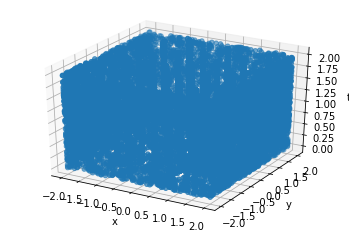

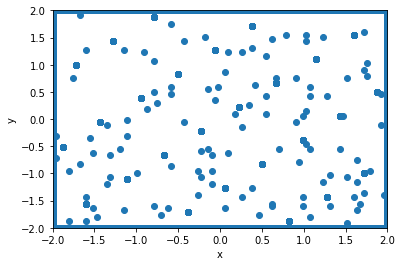

Amount of training data: 62530


In [22]:
# Data-points
N_u = 52000 # Default 52000 (ONLY FOR DENSE DATA)
# Number of measurement stations (ONLY FOR SPARSE DATA)
N_m = 26 # Default 26 
timestep = 1


# FNN size
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Activation function
activation_func = tf.keras.activations.tanh


# ADAM 
tf_epochs = 25000 # Epochs w/ ADAM
learning_rate = 0.001
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# True values
lambdas_star = (-1.4, -1.0, 1.0)

batch_size = 62530 # Full batch = Amount of training data shown below

f_param = 0.01 # Default 0.01
u_param = 10.0 # Default 10.0


# Load data
inc_bounds = True
random_pos = False
sparse = True
noise = 0.05 
prcnt = 0.013 # Amount of boundary points

### User needs to input path location. For example: path = os.path.join("/folder/2D_ADE_Training_Data.mat") ###

path = #### Path to 2D Training data #### 
x, y, t, X, Y, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb = LoadData(path, N_u, N_m, noise, inc_bounds, prcnt, sparse, random_pos, timestep, method=2)

TrainingDataPlotter(X_u_train, ub, lb)

In [17]:
# Creating the model and training
logger = Logger(frequency=1)
logger.set_error_fn(error)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, ub, lb, f_param, u_param, activation_func)

TensorFlow version: 2.7.0
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: True


In [23]:
loss_history, l1_history, l2_history, l3_history, elapsed_time = pinn.fit(X_u_train, u_train, tf_epochs, batch_size = batch_size)


Training started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 20)                80        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20

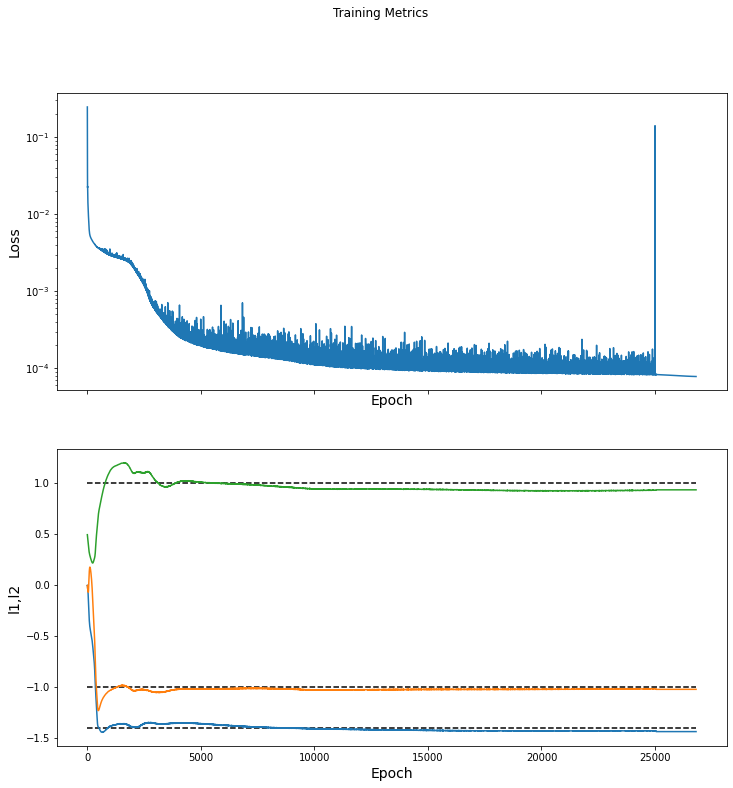

In [24]:
LossParameterPlotter(loss_history, l1_history, l2_history, l3_history)

In [20]:
X_test, Y_test, u_star_plot, u_plot, u_train_pred, trained_weights, pred_params = ExtractData(pinn, X_star, X_u_train)

In [ ]:
savemat('PINNresultsInverseWeightedNm=26.mat', {'u_pred': u_plot, 'u_true': u_star_plot, 'loss_history': loss_history, 'l1_history': l1_history, 'l2_history': l2_history, 'l3_history': l3_history, 
                           'X_u_train': X_u_train, 'u_train': u_train, 'u_train_pred': u_train_pred, 'X': X_test, 'Y': Y_test, 
                           'layers': layers, 'Nm': N_m, 'Nu': N_u, 'noise': noise, 'u_param': u_param, 'f_param': f_param, 'batch_size': batch_size, 'learning_rate': learning_rate})

No handles with labels found to put in legend.


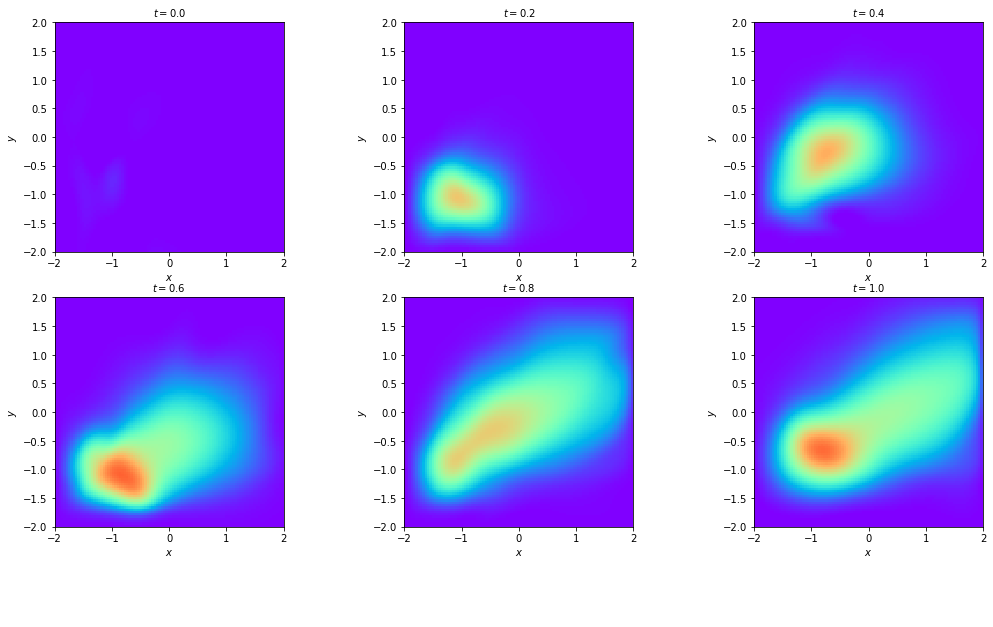

In [21]:
DiscretePlotter(t,X_test,Y_test,u_plot,ub,zmax=0.3,zmin=0.0,cmap='rainbow')

No handles with labels found to put in legend.


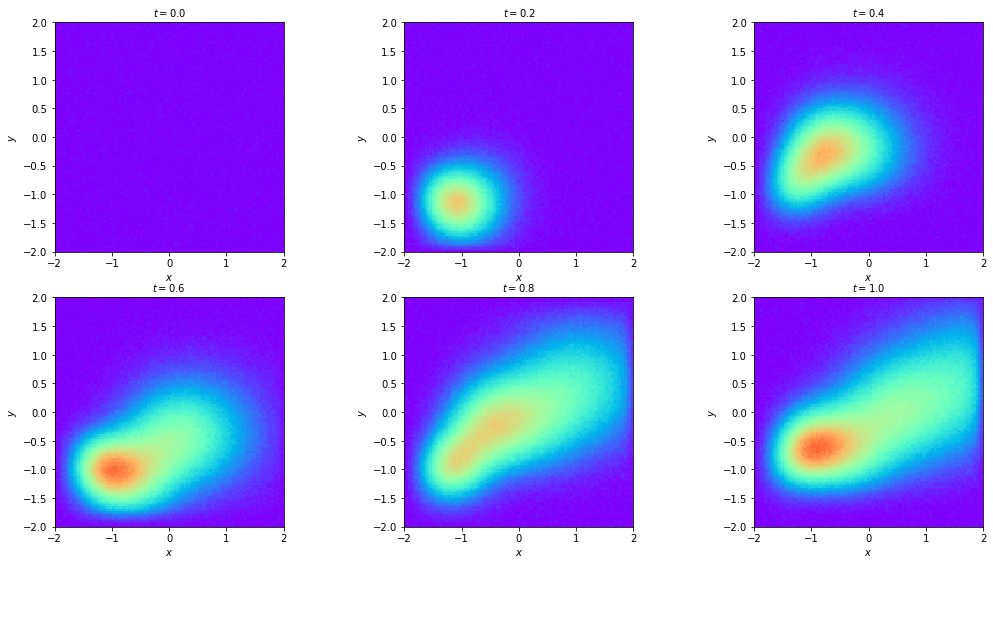

In [ ]:
DiscretePlotter(t,X_test,Y_test,u_star_plot,ub,zmax=0.3,zmin=0.0,cmap='rainbow')